# SHAP 

The SHAP (SHapley Additive exPlanations) method offers a framework for leveraging Shapley Values, a concept rooted in **Game Theory**.


Let's first create and train a model we want to evaluate 
  

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Data import 

Let's us MNIST data set. To make our example even more clearer, we will classify only between 1 and 7. Usually the hardest to identify due to there similarity in script wrtting. 

In [3]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch

class SubsetMNIST(Dataset):
    def __init__(self, original_dataset, classes=[1, 7]):
        self.data = []
        self.targets = []
        
        # Define the transformation to convert images to tensors
        transform = transforms.Compose([transforms.ToTensor()])
        
        # Filter dataset to only include the classes you want
        for i in range(len(original_dataset)):
            img, label = original_dataset[i]
            if label in classes:
                # Apply the transformation to the image
                img = transform(img)
                
                # Remap labels: 1 -> 0, 7 -> 1
                if label == 1:
                    label = 0
                elif label == 7:
                    label = 1
                
                self.data.append(img)
                self.targets.append(label)
        
        # Convert the list of targets to a tensor
        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

# Load the original MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Create a subset of the MNIST dataset containing only classes 1 and 7
train_dataset = SubsetMNIST(full_train_dataset, classes=[1, 7])
test_dataset = SubsetMNIST(full_test_dataset, classes=[1, 7])


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


## Model :

Let's now build our simple CNN model

In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.pool = nn.AvgPool2d(2, 2)  # 28x28 -> 14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 2)  # 32 channels * 14x14 spatial size -> 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        if x.ndim == 2:
            x = x.unsqueeze(0) # add a batch size
        if x.ndim == 3:
            x = x.unsqueeze(1) # add a channel dimension 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  # Pooling to reduce the size
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc1(x)
       
        return x

### Training 
Let's train it for a few epochs :

In [5]:
# Initialize the model, criterion, and optimizer
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Set number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/5], Loss: 0.0543
Epoch [2/5], Loss: 0.0152
Epoch [3/5], Loss: 0.0123
Epoch [4/5], Loss: 0.0089
Epoch [5/5], Loss: 0.0084
Training complete!


In [6]:
correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 99.86%


### Evaluation : 

Finally let's evaluate to check the robustness of our model

torch.Size([5, 1, 28, 28])


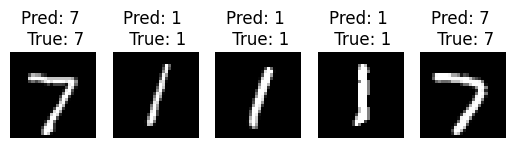

Accuracy on test set: 99.86%


In [7]:
import matplotlib.pyplot as plt


# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader))  # Get a batch of images
outputs = model(images)
print(images.shape)
# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Plot the first 5 images in the batch with their predicted and true labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze to remove unnecessary dimension
    plt.title(f"Pred: {(predicted[i].item())*6+1} \n True: {(labels[i].item())*6+1}")
    plt.axis('off')

plt.show()

# Compute accuracy on the test dataset
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100  # Accuracy as percentage
print(f"Accuracy on test set: {accuracy:.2f}%")



We can now check the one that the model struggled with

In [8]:
images[0].shape

torch.Size([1, 28, 28])

index 329
True label:  tensor(7)
Pred label:  tensor(1)


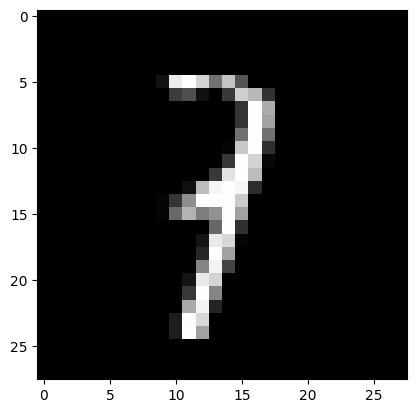

index 662
True label:  tensor(1)
Pred label:  tensor(7)


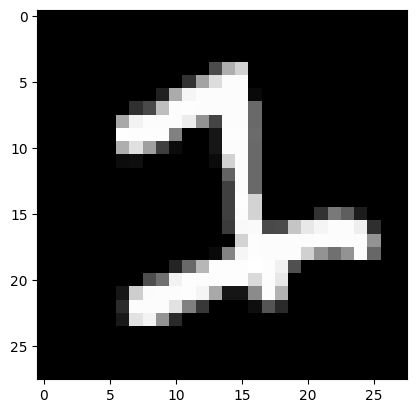

index 1411
True label:  tensor(7)
Pred label:  tensor(1)


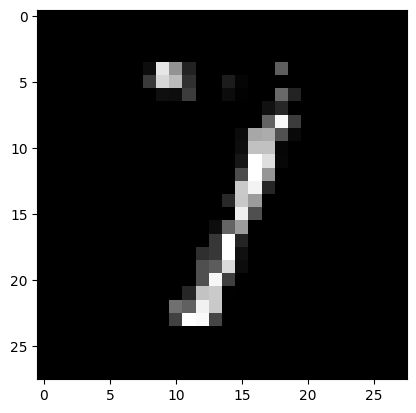

In [9]:
test_all = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
wrong_label =[]
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_all:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(images)):
            if (predicted [i] != labels[i]) : 
                print('index', i)
                print('True label: ', labels[i]*6+1)
                print('Pred label: ', predicted[i]*6+1)
                wrong_label.append(i)
                plt.imshow(images[i].squeeze(), cmap="gray")
            
                plt.show()

## SHAP

### Exact Shapley value 

In game theory, **Shapley Values represent the contribution $\phi_i$ of a player $i$ within a coalition $S$ by comparing the outcomes of scenarios where the player is present  $v(S \cup \{i\})$ versus absent $v(S)$**.
\begin{equation}
  \phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! \, (|N| - |S| - 1)!}{|N|!} \, \left[ v(S \cup \{i\}) - v(S) \right]
\end{equation}

Applied to XAI, this involves computing the difference in model outputs between these scenarios, but ends up being difficulte to compute in most real applications due to the high dimensionality of the data.


In [11]:
pow(2,28*28)

101745825697019260773923519755878567461315282017759829107608914364075275235254395622580447400994175578963163918967182013639660669771108475957692810857098847138903161308502419410142185759152435680068435915159402496058513611411689167650816

This is the number of coalition we would have to compute to assess the contribution of each pixel. 

Here we explored two naive approaches : 
- 1 : We gather image into a  4x4 images
- 2 : We take a sample randomly an amount of coalition that we assume could approximate the effect of each pixel

#### 1: Using 4X4 patches

In [12]:
import random
from itertools import combinations
import math

def power_set(iterable, num_sets=None):
    if num_sets == None :
        """Generate all subsets of a given iterable, excluding full set."""
        s = list(iterable)
        return [set(comb) for r in range(1, len(s)) for comb in combinations(s, r)]

    else : 
        """Generate a fixed number of random subsets of a given iterable, excluding the full set."""

        s = list(iterable)
        subsets = set()
        
        # Keep generating random subsets until we have the desired number
        while len(subsets) < num_sets:
            r = random.randint(0, len(s)-1)  # Random size of subset (excluding the full set)
            random_subset = set(random.sample(s, r))
            
            if random_subset not in subsets:
                subsets.add(frozenset(random_subset))  # Use frozenset to avoid duplicates
        
    return [set(subset) for subset in subsets]


In [13]:
# Function to display the segmented image with 16 parts
def display_segmented_image(image, activation_mask):
    """
    Display the segmented image where each segment is activated/deactivated based on the mask.
    
    Parameters:
        image: numpy array of shape (28, 28) representing the grayscale image
        activation_mask: numpy array of shape (16,) where each element is 1 (active) or 0 (inactive)
    """
    # Create a copy of the image to modify based on activation
    modified_image = np.zeros_like(image)
    
    row_size = 7 
    col_size = 7  
    
    for i in range(4): 
        for j in range(4):  
            # Check if the segment is activated (1) or deactivated (0)
            part_index = i * 4 + j
            if activation_mask[part_index] == 1:
                # Activate the segment, keeping original values from the image
                modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \
                    image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size]
    return modified_image

def create_binary_list(indices, size=16):
    binary_list = [0] * size  
    for i in indices:
        if 0 <= i < size:  
            binary_list[i] = 1
    return binary_list

65534
Activation Mask:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_84234/2774494647.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \


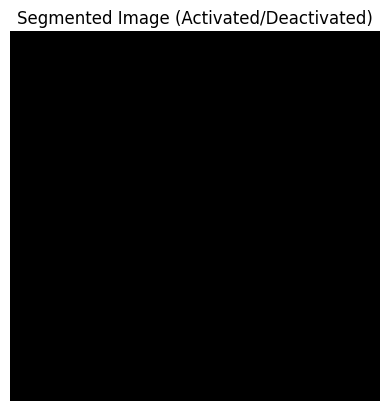

In [14]:
sets = power_set(set(range(16)))
print(len(sets))
# Example image: Random 28x28 grayscale image 
image = images[237].squeeze()
binary_set = create_binary_list(sets[0])# Display the original and segmented image
print("Activation Mask: ", binary_set)
modified_image = display_segmented_image(image, binary_set)
plt.imshow(modified_image, cmap='gray')
plt.title('Segmented Image (Activated/Deactivated)')
plt.axis('off')
plt.show()

We still deal with 65k sets.

Each set is a version of the image. For each part of the image (block of 7x7 pixels), we look at the difference of model ouput on each coalition. 

We then weight it using the Shapley Value formula : 

\begin{equation}
\frac{|S|! \, (|N| - |S| - 1)!}{|N|!}
\end{equation}

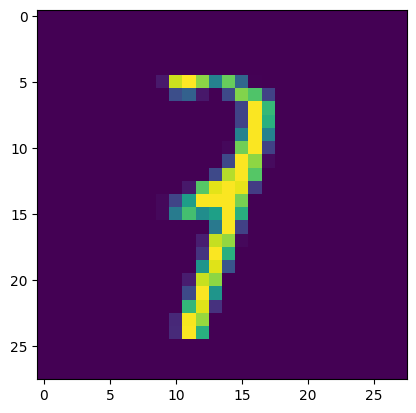

In [15]:
image = images[329].squeeze()

plt.imshow(image.reshape(28,28))

In [16]:
n = 16
shapley_vals = np.zeros(n)
accuracy_subset = []
all_subset = []
subsets = power_set(set(range(n)), 10000)
class_assessed = 0 #Measuring the contribution of being in class 0 ---> NUMBER 1

for i in range(n):
    
    for subset in subsets:
        if i in subset: 
            subset_with_i = list(subset) 
            subset_without_i = subset
            subset_without_i.discard(i) 
        else : 
            subset_without_i = list(subset) 
            subset_with_i = list(subset) + [i]

        weight = (math.factorial(len(subset_without_i)) * math.factorial(n - len(subset_without_i) - 1)) / math.factorial(n)# check len of subset


        image_activated = display_segmented_image(image, create_binary_list(subset_with_i))
        image_deactivated = display_segmented_image(image, create_binary_list(subset_without_i))
        image_activated = np.expand_dims(image_activated, axis=0)
        image_deactivated = np.expand_dims(image_deactivated, axis=0)
        v_S_i = model(torch.tensor(np.expand_dims(image_activated, axis=0)))[0][class_assessed].item()   
        v_S = model(torch.tensor(np.expand_dims(image_deactivated, axis=0)))[0][class_assessed].item()

        if v_S_i<0: 
            accuracy_subset.append(0)
        else: accuracy_subset.append(1)

        all_subset.append(len(subset))

        # Compute marginal contribution
        shapley_vals[i] += weight * (v_S_i - v_S)


    accuracy = correct / total * 100
    print(f"{i}th x done")



/tmp/ipykernel_84234/2774494647.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \


0th x done
1th x done
2th x done
3th x done
4th x done
5th x done
6th x done
7th x done
8th x done
9th x done
10th x done
11th x done
12th x done
13th x done
14th x done
15th x done


 The following plot is mostly here as a sanity check: 

 What it shows is that the more the image has region activated, the more the 

[]

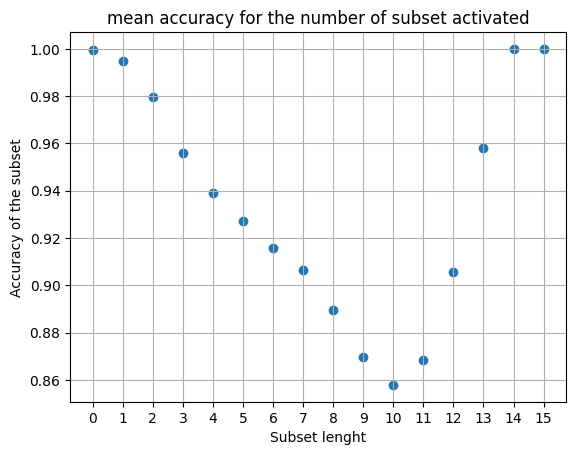

In [17]:
length_to_sum = {}  # Stores sum of values for each length
length_to_count = {}  # Stores count of occurrences for each length

# Group sums and counts by length
for length, value in zip(all_subset, accuracy_subset):
    if length in length_to_sum:
        length_to_sum[length] += value
        length_to_count[length] += 1
    else:
        length_to_sum[length] = value
        length_to_count[length] = 1

# Compute mean for each length
mean_by_length = {length: length_to_sum[length] / length_to_count[length] for length in length_to_sum}

plt.scatter(mean_by_length.keys(),mean_by_length.values())
plt.xlabel('Subset lenght')
plt.ylabel('Accuracy of the subset')
plt.title('mean accuracy for the number of subset activated')
plt.xticks(range(0,18))
plt.grid()
plt.plot()

In [18]:
shapley_vals
normalized_arr = (shapley_vals - np.min(shapley_vals)) / (np.max(shapley_vals) - np.min(shapley_vals))
normalized_arr 


array([0.03383929, 0.        , 0.01522451, 0.03383929, 0.03383929,
       0.07105116, 0.11265631, 0.03383929, 0.03383929, 0.60801661,
       1.        , 0.03383929, 0.03383929, 0.83738338, 0.03383929,
       0.03383929])

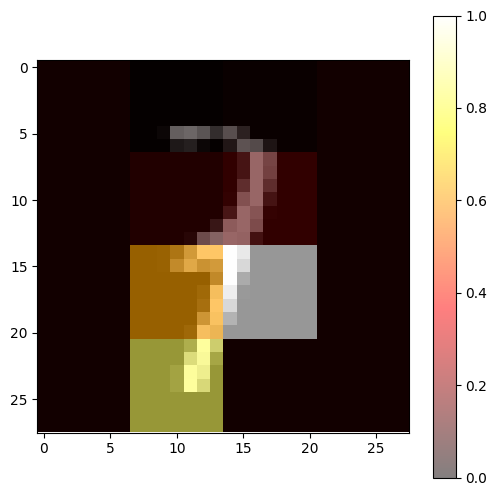

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
region_values = normalized_arr.reshape(4,4)
# Display the MNIST image
ax.imshow(image, cmap='gray', interpolation='nearest')

# Now, overlay the heatmap
# Scale the region_values to match the dimensions of the MNIST image
heatmap = np.kron(region_values, np.ones((7, 7)))  # Repeat the region values to match the 28x28 grid

# Overlay the heatmap with a transparent colormap
# You can adjust alpha for transparency
ax.imshow(heatmap, cmap='hot', alpha=0.2)

# Show the plot
plt.colorbar(ax.imshow(heatmap, cmap='hot', alpha=0.5), ax=ax)  # Add colorbar for the heatmap
plt.show()

#### 2: Using each pixel


torch.Size([28, 28])


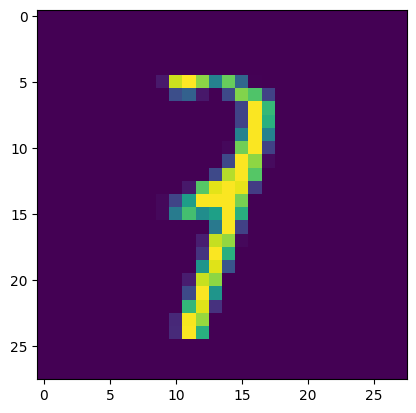

In [20]:
image = images[329].squeeze()
print(image.shape)
plt.imshow(image)

{0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 20, 21, 22, 23, 26, 28, 29, 30, 33, 35, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 57, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 73, 76, 78, 80, 84, 85, 86, 90, 91, 92, 94, 95, 96, 99, 101, 104, 105, 106, 107, 108, 110, 113, 115, 118, 120, 121, 122, 123, 125, 126, 127, 128, 131, 132, 133, 135, 137, 138, 141, 142, 143, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 158, 159, 160, 161, 165, 166, 169, 170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 189, 190, 191, 192, 194, 195, 196, 200, 201, 202, 204, 205, 208, 209, 211, 212, 213, 214, 217, 218, 219, 220, 222, 225, 226, 230, 233, 234, 235, 236, 237, 240, 242, 244, 248, 253, 254, 255, 256, 257, 259, 260, 262, 263, 264, 268, 270, 273, 276, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 293, 294, 298, 302, 304, 307, 308, 310, 312, 313, 314, 315, 316, 317, 318, 319, 322, 324, 326, 327, 328, 329, 330, 332, 333, 334, 335, 336, 337, 338, 340, 341, 346, 349, 

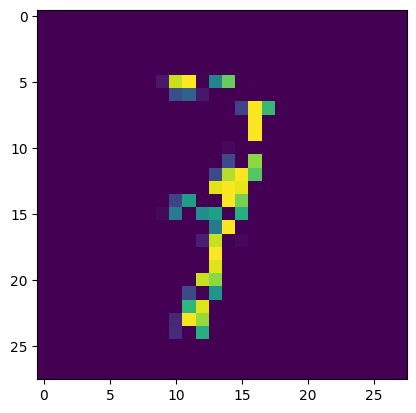

In [21]:
n = 28*28

subsets = power_set(set(range(n)), 1000)
print(subsets[0])
bin_list = create_binary_list(subsets[0], n)
def mask_pixel(image, index_list): 
    modified_image = image.clone()
    for i in range(28):
        for j in range(28):
            index = i * 28 + j
            if index_list[index] == 0:
                modified_image[i, j] = 0
    return modified_image
    

plt.imshow(mask_pixel(image, bin_list))

In [22]:
n = 28*28
shapley_vals = np.zeros(n)
accuracy_subset = []
all_subset = []
subsets = power_set(set(range(n)), 10)
class_assessed = 1 #Measuring the contribution of being in class 0 ---> NUMBER 1

for i in range(n):
    
    for subset in subsets:
        if i in subset: 
            subset_with_i = list(subset) 
            subset_without_i = subset
            subset_without_i.discard(i) 
        else : 
            subset_without_i = list(subset) 
            subset_with_i = list(subset) + [i]

        weight = (math.factorial(len(subset_without_i)) * math.factorial(n - len(subset_without_i) - 1)) / math.factorial(n) # Compute the weight as described in Shapley value


        image_activated = mask_pixel(image, create_binary_list(subset_with_i,n))
        image_deactivated = mask_pixel(image, create_binary_list(subset_without_i,n))
        image_activated = np.expand_dims(image_activated, axis=0)
        image_deactivated = np.expand_dims(image_deactivated, axis=0)

        v_S_i = model(torch.tensor(np.expand_dims(image_activated, axis=0)))[0][class_assessed].item()   
        v_S = model(torch.tensor(np.expand_dims(image_deactivated, axis=0)))[0][class_assessed].item()

        if v_S_i<0: 
            accuracy_subset.append(0)
        else: accuracy_subset.append(1)

        all_subset.append(len(subset))

        # Compute marginal contribution
        shapley_vals[i] += weight * (v_S_i - v_S)


    accuracy = correct / total * 100
    print(f"{i}th x done")

0th x done
1th x done
2th x done
3th x done
4th x done
5th x done
6th x done
7th x done
8th x done
9th x done
10th x done
11th x done
12th x done
13th x done
14th x done
15th x done
16th x done
17th x done
18th x done
19th x done
20th x done
21th x done
22th x done
23th x done
24th x done
25th x done
26th x done
27th x done
28th x done
29th x done
30th x done
31th x done
32th x done
33th x done
34th x done
35th x done
36th x done
37th x done
38th x done
39th x done
40th x done
41th x done
42th x done
43th x done
44th x done
45th x done
46th x done
47th x done
48th x done
49th x done
50th x done
51th x done
52th x done
53th x done
54th x done
55th x done
56th x done
57th x done
58th x done
59th x done
60th x done
61th x done
62th x done
63th x done
64th x done
65th x done
66th x done
67th x done
68th x done
69th x done
70th x done
71th x done
72th x done
73th x done
74th x done
75th x done
76th x done
77th x done
78th x done
79th x done
80th x done
81th x done
82th x done
83th x done
84

[]

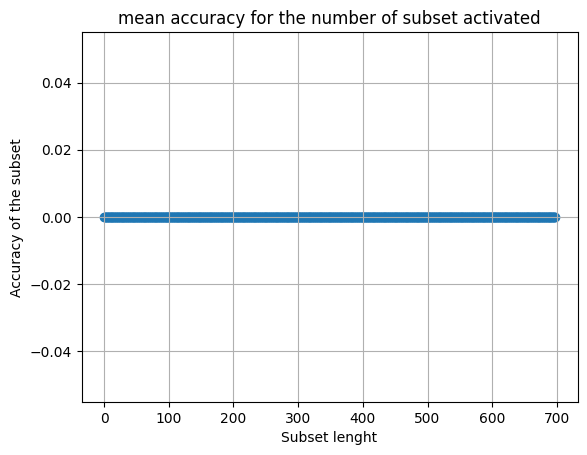

In [23]:
length_to_sum = {}  # Stores sum of values for each length
length_to_count = {}  # Stores count of occurrences for each length

# Group sums and counts by length
for length, value in zip(all_subset, accuracy_subset):
    if length in length_to_sum:
        length_to_sum[length] += value
        length_to_count[length] += 1
    else:
        length_to_sum[length] = value
        length_to_count[length] = 1

# Compute mean for each length
mean_by_length = {length: length_to_sum[length] / length_to_count[length] for length in length_to_sum}

plt.scatter(mean_by_length.keys(),mean_by_length.values())
plt.xlabel('Subset lenght')
plt.ylabel('Accuracy of the subset')
plt.title('mean accuracy for the number of subset activated')
plt.grid()
plt.plot()

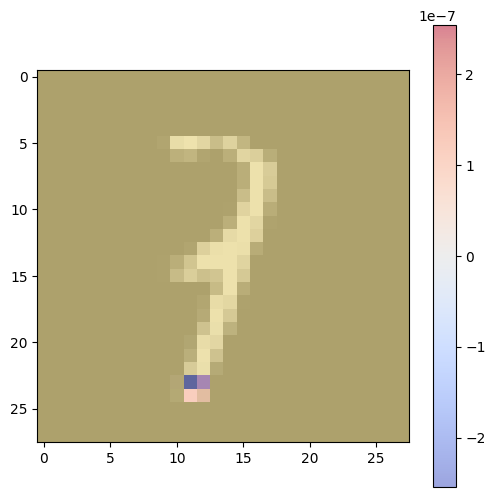

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = shapley_vals.reshape(28,28)
# Display the MNIST image
ax.imshow(image, cmap='gray', interpolation='nearest')

# Now, overlay the heatmap
# Scale the region_values to match the dimensions of the MNIST image

# Overlay the heatmap with a transparent colormap
# You can adjust alpha for transparency
ax.imshow(heatmap, cmap='hot', alpha=0.5)

# Show the plot
plt.colorbar(ax.imshow(heatmap, cmap='coolwarm', vmin=-np.abs(heatmap).max(), vmax=np.abs(heatmap).max(), alpha=0.5), ax=ax)  # Add colorbar for the heatmap
plt.show()

### KernelSHAP for Shapley Value
Kernel SHAP is a model agnostic method to approximate SHAP values using ideas from LIME and Shapley values.

In the case of KernelSHAP, a surrogate model is trained to mimic the behavior of the model, allowing for faster processing of the instances.  


\begin{equation}
  argmin_{\phi} \sum_{z'}\left[f(h_x(z'))- \phi_0- \sum_{i=1}^{M}\phi_i z_i' \right]^2 \pi_x(z')
\end{equation}

while in LIME the weight $\pi$ control the locality of the instance, here it is computed based on a Shapley kernel : 

\begin{equation}
 \pi_x(z')= \frac{(M - 1)}{\binom{M}{|z'|} \cdot |z'| \cdot (M - |z'|)}
\end{equation}

$\phi_i$ is the SHAP values of feature $i$, it is what we are trying to find. 
$z$ represents the mask, it indicates which feature is activated in this coalition. 

This weight ensure that the largest coalition contribute the most in the fit of the linear classifier. 

This linear classifier allows a better generalization, from a small number of coalition, it approximates the Shapley Value for each of them.


In the following section we are going to compare first implement an 'home made' kernelSHAP method and then compare it with the official library

#### Homemade

In [ ]:
image = images[329].squeeze() # Image to assess

#plt.imshow(image.reshape(28,28))

Let's reproduce this : 
\begin{equation}
  argmin_{\phi} \sum_{z'}\left[f(h_x(z'))- \phi_0- \sum_{i=1}^{M}\phi_i z_i' \right]^2 \pi_x(z')
\end{equation}


In [ ]:
from sklearn.linear_model import LinearRegression
from math import comb

def kernel_shap(model, x, class_assessed):
    model.eval()
    with torch.no_grad():
        # First we generate the coalitions, and sample a certain amount of them
        M = x.numel()  # Total number of pixels (e.g., 784 for 28x28)
        
        subsets = power_set(set(range(M)), 10000)  # Generate coalitions: [Number of pixel, Coalition sampled from it]

        X = []  
        y = []  
        weights = []  # shapley kernel weights

        for x in subsets:
            z = create_binary_list(x,M)
            h = torch.tensor(np.expand_dims(np.expand_dims(mask_pixel(image, z), axis=0), axis=0))
            f = model(h)[0][class_assessed]
            # Compute kernel weight
            z_len = np.array(z).sum().item()
            if z_len == 0 or z_len == M:
                continue  # skip empty and full coalitions

            weight = (M - 1) / (comb(M, int(z_len)) * z_len * (M - z_len)) # Pi_xShapley Value Kernel

            X.append(np.array(z))
            y.append(f)
            weights.append(weight)

        # Fit weighted linear regression
        reg = LinearRegression(fit_intercept=True) 
        X = np.array(X)
        y = np.array(y)
        weights = np.array(weights)
        reg.fit(X, y, sample_weight=weights) #'minimization'

        phi_0 = reg.intercept_
        phi = reg.coef_

        return phi_0, phi.reshape(28, 28)  # Return SHAP values as 28x28 heatmap


In [ ]:
classe_assessed = 1
phi_0, shap_values = kernel_shap(model, image, classe_assessed)


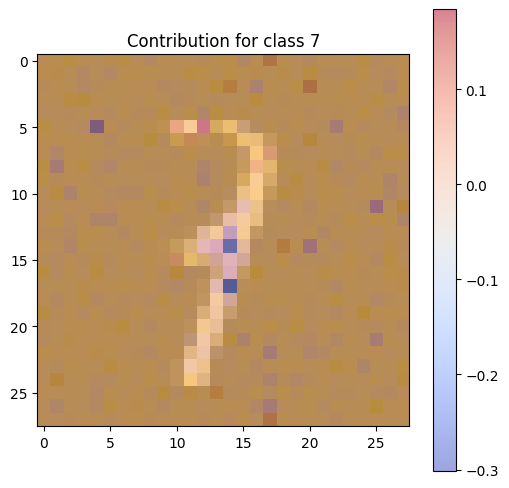

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
# Display the MNIST image
ax.imshow(image, cmap='gray', interpolation='nearest')

# Now, overlay the heatmap
# Scale the region_values to match the dimensions of the MNIST image

# Overlay the heatmap with a transparent colormap
# You can adjust alpha for transparency
ax.imshow(shap_values, cmap='hot', alpha=0.5)

# Show the plot
plt.colorbar(ax.imshow(shap_values, cmap='coolwarm', alpha=0.5), ax=ax)  # Add colorbar for the heatmap
plt.title(label=f"Contribution for class {classe_assessed*6+1}")
plt.show()

In [10]:
import shap



/home/raph2268/miniconda3/envs/XAI_methods/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# A wrapper function to make predictions compatible with SHAP
def predict_fn(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    x_tensor = x_tensor.view(-1, 1, 28, 28)

    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.numpy()

In [12]:
shap_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)


batch = next(iter(test_all))
images, _ = batch

background = np.array(images[:10])
background_flat = background.reshape((background.shape[0], -1))

test_images =np.array(images[237])
test_images_flat = test_images.reshape((test_images.shape[0], -1))



/tmp/ipykernel_165407/2856826899.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  background = np.array(images[:10])
/tmp/ipykernel_165407/2856826899.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_images =np.array(images[237])


In [13]:
explainer = shap.KernelExplainer(predict_fn, background_flat)


In [14]:
shap_values = explainer.shap_values(test_images_flat, nsamples = 2000)

100%|██████████| 1/1 [00:13<00:00, 13.50s/it]


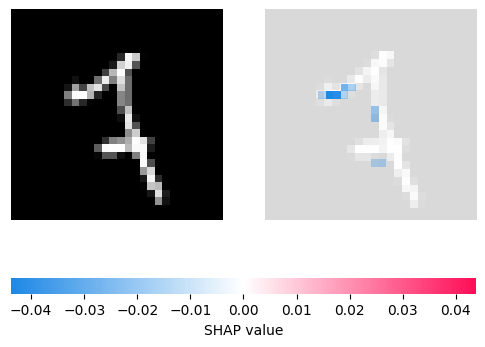

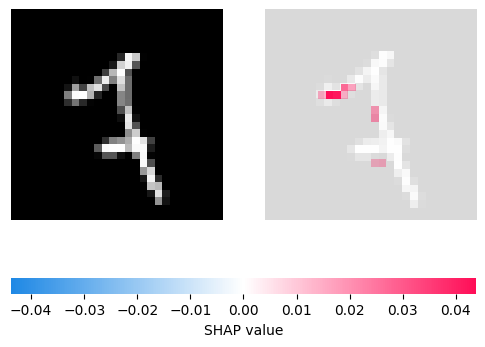

In [17]:
sv_reshaped = shap_values.reshape(1,28,28,2)

# Also make sure test_images has shape: (N, 28, 28, 1)
test_images_reshaped = test_images.reshape((-1, 28, 28, 1))

# Now try plotting
shap.image_plot(np.expand_dims(sv_reshaped[:,:,:,0], axis=3), test_images_reshaped)
shap.image_plot(np.expand_dims(sv_reshaped[:,:,:,1], axis=3), test_images_reshaped)

In [18]:
DeepSHAP = shap.DeepExplainer(predict_fn, background_flat)


ModuleNotFoundError: No module named 'tensorflow'

In [61]:


DeepSHAP = shap.DeepExplainer(model, background.detach().numpy())
shap_values = e.shap_values(test_images)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

What is the SHAP library doing better : 
- Memoization : When calculating the Shapley value for feature i, SHAP needs to evaluate the model's prediction for subsets of features where feature i is included and excluded. If SHAP has already computed the prediction for a particular subset of features, it will reuse that result instead of recalculating the prediction from scratch.
- Sampling strategy: SHAP uses weighted random sampling, where the probability of selecting a coalition size (i.e., the number of features included in a subset) is biased toward subsets with sizes near M/2
- Use of a background Dataset: The background in SHAP is formed by talking the mean image of several images


In [ ]:
shap_values.shape

(6, 1, 28, 28, 2)

In [ ]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

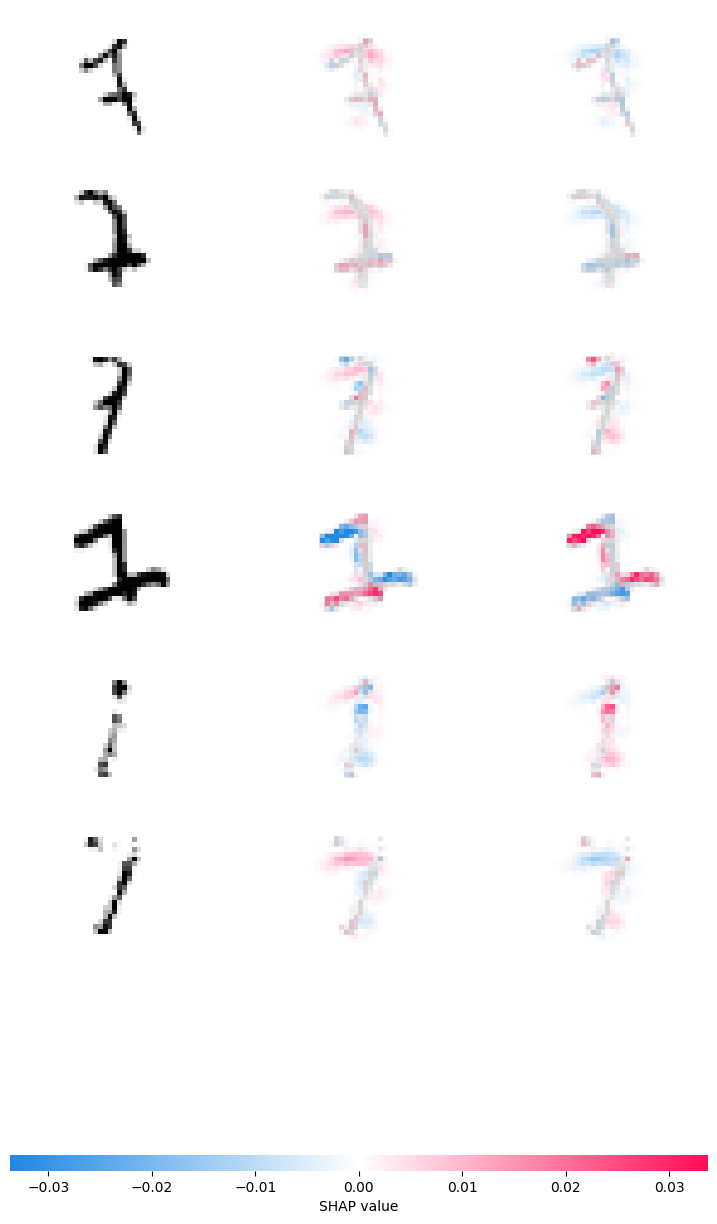

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)

Remark : 

- In this example we are using grayscale, so we are only computing the gradient of each pixel on one dimension. In case the input is several dimension, the 

- One sanity test to run is to test to check the completeness. The completness property is imply by the sensitivity $\sum_{i=1}^{n}IntegratedGrads(x)=F(x) - F(x')$